# Compute embeddings for the encoders of CNEP

 * https://github.com/ncbi-nlp/BioSentVec#biosentvec
 * https://github.com/epfml/sent2vec
 * https://github.com/ncbi-nlp/BioSentVec/blob/master/BioSentVec_tutorial.ipynb
 * https://arxiv.org/abs/1810.09302

In [2]:
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
import pickle
from tqdm import tqdm
import numpy as np
import torch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
stop_words = set(stopwords.words('english'))
punctuation_less = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~'

def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

def preprocess_sentence_leave_dot(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation_less and token not in stop_words]

    return ' '.join(tokens)

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["notes"], padding=True, truncation=True,
                        max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

tokenizer.pad_token = tokenizer.eos_token


Downloading:   0%|          | 0.00/792 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'pickle' is not defined

In [7]:
# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

dataset = 'val' #,'val','test']
train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

In [11]:
train_data.keys()

dict_keys(['notes', 'labels', 'inputs', 'eventsnotes'])

In [49]:
from datasets import load_dataset
from datasets import Dataset
# >>> my_dict = {"a": [1, 2, 3]}
# >>> dataset = Dataset.from_dict(my_dict)

messages = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]

# ds = Dataset.from_dict({'notes': train_data['notes'][:16]})
ds = Dataset.from_dict({'notes': messages})
# embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds.map(embed_text, batched=True, batch_size=16)
# embs_test = train_data.map(embed_text, batched=True, batch_size=16)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
embeds = []
for d in embs_valid:
    print(np.array(d['embedding']).shape)
    embeds.append(d['embedding'])

(1280,)
(1280,)
(1280,)
(1280,)
(1280,)
(1280,)
(1280,)
(1280,)
(1280,)


In [51]:
embeds = torch.nn.functional.normalize(torch.Tensor(embeds))
heatmap = embeds @ embeds.T
heatmap

tensor([[1.0000, 0.9075, 0.6679, 0.7880, 0.6980, 0.5783, 0.6484, 0.6498, 0.5737],
        [0.9075, 1.0000, 0.6836, 0.7296, 0.6542, 0.5786, 0.6605, 0.5866, 0.5723],
        [0.6679, 0.6836, 1.0000, 0.7007, 0.7272, 0.6003, 0.6312, 0.5730, 0.6184],
        [0.7880, 0.7296, 0.7007, 1.0000, 0.7188, 0.6485, 0.8842, 0.6700, 0.6366],
        [0.6980, 0.6542, 0.7272, 0.7188, 1.0000, 0.5933, 0.6388, 0.7619, 0.7244],
        [0.5783, 0.5786, 0.6003, 0.6485, 0.5933, 1.0000, 0.6543, 0.5418, 0.5876],
        [0.6484, 0.6605, 0.6312, 0.8842, 0.6388, 0.6543, 1.0000, 0.5851, 0.6232],
        [0.6498, 0.5866, 0.5730, 0.6700, 0.7619, 0.5418, 0.5851, 1.0000, 0.7295],
        [0.5737, 0.5723, 0.6184, 0.6366, 0.7244, 0.5876, 0.6232, 0.7295, 1.0000]])

In [58]:
embeds.shape

torch.Size([9, 1280])

features.shape=torch.Size([9, 1280])


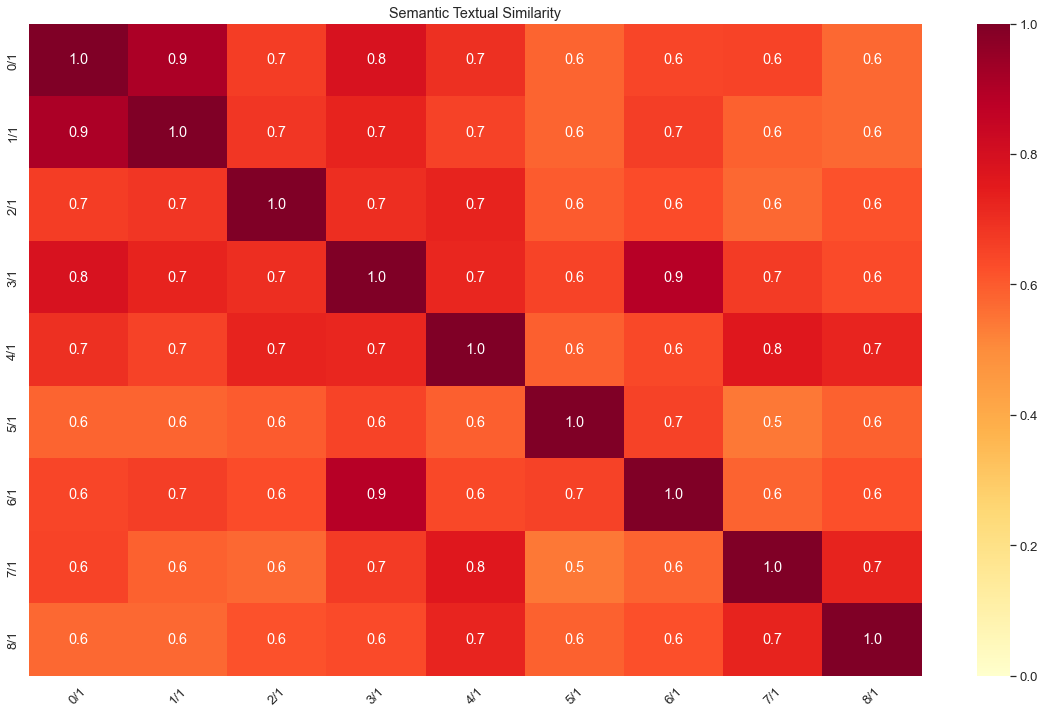

In [60]:
import seaborn as sns
import numpy as np
import torch

def plot_similarity(labels, features, rotation, print_labels=True):
    print(f"{features.shape=}")
    # corr = np.inner(features, features)
    corr = features @ features.T
    #print(corr)
    labels = [m[:25] + '/' + str(len(m)) for m in labels]
    sns.set(rc = {'figure.figsize':(20,12)})
    sns.set(font_scale=1.2)
    g = sns.heatmap(corr,
                      xticklabels=labels,
                      yticklabels=labels,
                      vmin=0,
                      vmax=1,
                      annot=print_labels, fmt='.1f',
                      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity([f'{n}' for n in range(len(ds))], embeds, 45)

# 1. Doc2Vec Model

In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /home/thetaphipsi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
seq_len = None # 2000

# Tokenization of each document
tokenized_sent = []

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train'] #,'val','test']

for dataset in datasets:
    embeds = []
    embeds_events = []
    train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

    for i in tqdm(range(len(train_data['notes']))):
        inputs = train_data['notes'][i][:seq_len]
        tokenized_sent.append(word_tokenize(inputs.lower()))
        
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]


100%|████████████████████████████████████| 13181/13181 [00:51<00:00, 256.07it/s]


In [16]:
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size = 768, window = 2, min_count = 2, epochs = 10)

## Print model vocabulary
# model.wv.key_to_index

In [17]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

u = model.infer_vector("Kerry was discovered by researchers on the remote Cornwallis Island. They picked up the signal and decided to try to find him.".lower().split())
v = model.infer_vector("A young humpback whale remained tangled in a shark net off the Gold Coast yesterday, despite valiant efforts by marine rescuers.".lower().split())

print(cosine(u, v))

0.42139584


In [21]:
seq_len = None # 2000
USE_CHUNKS = False

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train','val','test']

with torch.no_grad():
    for dataset in datasets:
        embeds = []
        embeds_events = []
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            if USE_CHUNKS:
                inputs = word_tokenize(train_data['notes'][i][:seq_len].lower())
                sentence_vector = model.infer_vector(inputs)
            else:
                inputs = word_tokenize(train_data['notes'][i][:seq_len].lower())
                sentence_vector = model.infer_vector(inputs)
            embeds.append(sentence_vector.reshape(-1))

        for i in tqdm(range(len(train_data['eventsnotes']))):
            if USE_CHUNKS:
                inputs = word_tokenize(train_data['eventsnotes'][i][:seq_len].lower())
                sentence_vector = model.infer_vector(inputs)
            else:
                inputs = word_tokenize(train_data['eventsnotes'][i][:seq_len].lower())
                sentence_vector = model.infer_vector(inputs)
            embeds_events.append(sentence_vector.reshape(-1))

        embeds = np.array(embeds)
        embeds_events = np.array(embeds_events)
        print(train_data['inputs'].shape, embeds.shape, embeds_events.shape)
        train_data['embeds'] = embeds
        train_data['embeds_events'] = embeds_events
        del train_data['notes']
        del train_data['eventsnotes']
        pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed_d2v.pickle', 'wb'))

100%|█████████████████████████████████████| 13181/13181 [09:46<00:00, 22.47it/s]


(13181, 48, 390) (13181, 768) (13181, 768)


100%|███████████████████████████████████████| 4216/4216 [02:36<00:00, 26.95it/s]


(4216, 48, 390) (4216, 768) (4216, 768)


100%|███████████████████████████████████████| 4204/4204 [02:34<00:00, 27.18it/s]


(4204, 48, 390) (4204, 768) (4204, 768)


# 2. Sent2Vec Model

In [3]:
# load Sent2Vec model
# model_path = '/Users/jplasser/Downloads/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model_path = '/home/thetaphipsi/Downloads/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()

try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [ ]:
# seq_len = None # 2000

# # data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
# data_path = './'

# datasets = ['train','val','test']

# for dataset in datasets:`
#     embeds = []
#     train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique.pickle', 'rb'))

#     for i in tqdm(range(len(train_data['notes']))):
#         sentence_vector = model.embed_sentence(preprocess_sentence(train_data['notes'][i][:seq_len]))
#         embeds.append(sentence_vector.reshape(-1))
        
#     embeds = np.array(embeds)
#     print(train_data['inputs'].shape, embeds.shape)
#     train_data['embeds'] = embeds
#     pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed.pickle', 'wb'))

In [9]:
import re

MINWORDS = 3

def windowsSentenceEmbedding(model, inputs):
    # construct sentences from the given input with the following properties:
    # 1. sentence has a maximum of 384 words (to stay in the realm of maximum 510 tokens in average)
    # 2. sentence is no shorter than 10 words
    # 3. a sentence should be constructed from words and a stop character in the end, holding the constraints above.
    
    if inputs[-1] != '.':
        inputs += ' .'
    sentences = re.findall("[a-z].*?[\.!?]", inputs, re.MULTILINE | re.DOTALL )

    sentences_ltmw = [s for s in sentences if len(s.split()) > MINWORDS]
    if len(sentences_ltmw) > 0:
        sentences = sentences_ltmw
    
    embeds = np.asarray([model.embed_sentence(s) for s in sentences])
    embedding = embeds.mean(axis=0)
    
    return embedding

# windowsSentenceEmbedding(model, "a b c . this is a good text ! why not leave it as it is .").shape

In [137]:
seq_len = None # 2000
USE_CHUNKS = False

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train','val','test']

with torch.no_grad():
    for dataset in datasets:
        embeds = []
        embeds_events = []
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            if USE_CHUNKS:
                inputs = preprocess_sentence_leave_dot(train_data['notes'][i][:seq_len])
                sentence_vector = windowsSentenceEmbedding(model, inputs)
            else:
                inputs = preprocess_sentence(train_data['notes'][i][:seq_len])
                sentence_vector = model.embed_sentence(inputs)
            embeds.append(sentence_vector.reshape(-1))

        for i in tqdm(range(len(train_data['eventsnotes']))):
            
            if USE_CHUNKS:
                inputs = preprocess_sentence_leave_dot(train_data['eventsnotes'][i][:seq_len])
                sentence_vector = windowsSentenceEmbedding(model, inputs)
            else:
                inputs = preprocess_sentence(train_data['eventsnotes'][i][:seq_len])
                sentence_vector = model.embed_sentence(inputs)
            embeds_events.append(sentence_vector.reshape(-1))

        embeds = np.array(embeds)
        embeds_events = np.array(embeds_events)
        print(train_data['inputs'].shape, embeds.shape, embeds_events.shape)
        train_data['embeds'] = embeds
        train_data['embeds_events'] = embeds_events
        del train_data['notes']
        del train_data['eventsnotes']
        pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed_s2v.pickle', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13181/13181 [03:01<00:00, 72.71it/s]


(13181, 48, 390) (13181, 700) (13181, 700)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4216/4216 [00:46<00:00, 89.82it/s]


(4216, 48, 390) (4216, 700) (4216, 700)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4204/4204 [00:47<00:00, 88.98it/s]


(4204, 48, 390) (4204, 700) (4204, 700)


# 3. SentenceTransformer Embeddings

 * https://github.com/UKPLab/sentence-transformers
     * https://github.com/UKPLab/sentence-transformers/issues/1300
 * https://github.com/yanzhangnlp/IS-BERT
     * https://github.com/yanzhangnlp/IS-BERT/blob/main/docs/pretrained_models.md

We can recommend this models as general purpose models. The best available models are:
- **roberta-large-nli-stsb-mean-tokens** - STSb performance: 86.39
- **roberta-base-nli-stsb-mean-tokens** - STSb performance: 85.44
- **bert-large-nli-stsb-mean-tokens** - STSb performance: 85.29
- **distilbert-base-nli-stsb-mean-tokens** - STSb performance:  85.16

[» Full List of STS Models](https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0)

I can recommend the **distilbert-base-nli-stsb-mean-tokens** model, which gives a nice balance between speed and performance.
     
 ## Models used
 
  * all-mpnet-base-v2
  * distilbert-base-nli-stsb-mean-tokens
  * roberta-base-nli-stsb-mean-tokens

In [3]:
# TODO
from sentence_transformers import SentenceTransformer, models

# model = SentenceTransformer('all-mpnet-base-v2')
# model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
# optional, not evaluated for now: model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
model = SentenceTransformer('stsb-mpnet-base-v2')

#Sentences are encoded by calling model.encode()

# sentences = ['my father was a rolling stone.']
# sentence_embeddings = model.encode(sentences)
# sentence_embeddings.shape

Downloading:   0%|          | 0.00/868 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/588 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
seq_len = None # 2000

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train','val','test']

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

with torch.no_grad():
    for dataset in datasets:
        embeds = []
        embeds_events = []
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            inputs = preprocess_sentence(train_data['notes'][i][:seq_len])
            sentence_vector = model.encode(inputs)
            embeds.append(sentence_vector.reshape(-1))

        for i in tqdm(range(len(train_data['eventsnotes']))):
            inputs = preprocess_sentence(train_data['eventsnotes'][i][:seq_len])
            sentence_vector = model.encode(inputs)
            embeds_events.append(sentence_vector.reshape(-1))

        embeds = np.array(embeds)
        embeds_events = np.array(embeds_events)
        print(train_data['inputs'].shape, embeds.shape, embeds_events.shape)
        train_data['embeds'] = embeds
        train_data['embeds_events'] = embeds_events
        del train_data['notes']
        del train_data['eventsnotes']
        pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed_ST_stsb-mpnet-base-v2.pickle', 'wb'))

100%|█████████████████████████████████████| 13181/13181 [04:55<00:00, 44.66it/s]


(13181, 48, 390) (13181, 768) (13181, 768)


100%|███████████████████████████████████████| 4216/4216 [01:22<00:00, 51.05it/s]


(4216, 48, 390) (4216, 768) (4216, 768)


100%|███████████████████████████████████████| 4204/4204 [01:22<00:00, 50.81it/s]


(4204, 48, 390) (4204, 768) (4204, 768)


# 4. Use the embeddings of BERT model

 * bert-base-uncased
 * https://huggingface.co/bert-base-uncased
 * https://huggingface.co/bert-large-uncased
 

In [3]:
# dmis-lab/biobert-base-cased-v1.2
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# BERT model
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")

# BERT large model
# tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
# model = AutoModel.from_pretrained("bert-large-uncased")

# RoBERTa  model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
seq_len = None # 2000
USE_CHUNKS = True

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train','val','test']

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

with torch.no_grad():
    for dataset in datasets:
        embeds = []
        embeds_events = []
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            if USE_CHUNKS:
                inputs = tokenizer(preprocess_sentence(train_data['notes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                sentence_vector = windowsEmbedding(model, inputs)
            else:
                inputs = tokenizer(preprocess_sentence(train_data['notes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                sentence_vector = model(**inputs).pooler_output.detach().cpu().numpy()
            embeds.append(sentence_vector.reshape(-1))

        for i in tqdm(range(len(train_data['eventsnotes']))):
            if USE_CHUNKS:
                inputs = tokenizer(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                sentence_vector = windowsEmbedding(model, inputs)
            else:
                inputs = tokenizer(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                sentence_vector = model(**inputs).pooler_output.detach().cpu().numpy()
            embeds_events.append(sentence_vector.reshape(-1))

        embeds = np.array(embeds)
        embeds_events = np.array(embeds_events)
        print(train_data['inputs'].shape, embeds.shape, embeds_events.shape)
        train_data['embeds'] = embeds
        train_data['embeds_events'] = embeds_events
        del train_data['notes']
        del train_data['eventsnotes']
        pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed_RoBERTa_chunked.pickle', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13181/13181 [09:34<00:00, 22.93it/s]


(13181, 48, 390) (13181, 768) (13181, 768)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4216/4216 [02:33<00:00, 27.42it/s]


(4216, 48, 390) (4216, 768) (4216, 768)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4204/4204 [02:34<00:00, 27.20it/s]


(4204, 48, 390) (4204, 768) (4204, 768)


In [7]:
train_data['embeds'].shape

(4204, 768)

# 5. Use the embeddings of BioBERT model

 * dmis-lab/biobert-base-cased-v1.2
 * https://huggingface.co/dmis-lab/biobert-base-cased-v1.2
 

In [5]:
# dmis-lab/biobert-base-cased-v1.2
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# BioBERT model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.2")


Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
seq_len = None # 2000
USE_CHUNKS = True

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train','val','test']

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

with torch.no_grad():
    for dataset in datasets:
        embeds = []
        embeds_events = []
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            if USE_CHUNKS:
                inputs = tokenizer(preprocess_sentence(train_data['notes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                sentence_vector = windowsEmbedding(model, inputs)
            else:
                inputs = tokenizer(preprocess_sentence(train_data['notes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                sentence_vector = model(**inputs).pooler_output.detach().cpu().numpy()
            embeds.append(sentence_vector.reshape(-1))

        for i in tqdm(range(len(train_data['eventsnotes']))):
            if USE_CHUNKS:
                inputs = tokenizer(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                sentence_vector = windowsEmbedding(model, inputs)
            else:
                inputs = tokenizer(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                sentence_vector = model(**inputs).pooler_output.detach().cpu().numpy()
            embeds_events.append(sentence_vector.reshape(-1))

        embeds = np.array(embeds)
        embeds_events = np.array(embeds_events)
        print(train_data['inputs'].shape, embeds.shape, embeds_events.shape)
        train_data['embeds'] = embeds
        train_data['embeds_events'] = embeds_events
        del train_data['notes']
        del train_data['eventsnotes']
        pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed_BioBERT_chunked.pickle', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13181/13181 [10:28<00:00, 20.99it/s]


(13181, 48, 390) (13181, 768) (13181, 768)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4216/4216 [02:46<00:00, 25.26it/s]


(4216, 48, 390) (4216, 768) (4216, 768)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4204/4204 [02:47<00:00, 25.17it/s]


(4204, 48, 390) (4204, 768) (4204, 768)


# 6. Use the embeddings of BERT models: ClinicalBERT and Discharge Summary BERT

 * https://github.com/EmilyAlsentzer/clinicalBERT
 * https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
 * https://huggingface.co/emilyalsentzer/Bio_Discharge_Summary_BERT
 * https://arxiv.org/abs/1904.03323

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Events Notes Model (EN)
tokenizer_EN = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model_EN = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Discharge Notes Model (DCN)
tokenizer_DCN = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
model_DCN = AutoModel.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_Discharge_Summary_BERT were not used when initializing BertModel: ['cls.prediction

In [6]:
#train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))
# tokens = tokenizer_EN.encode_plus(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
  
def windowsEmbedding(model, tokens):
    # define target chunksize
    chunksize = 512

    # split into chunks of 510 tokens, we also convert to list (default is tuple which is immutable)
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))

    # loop through each chunk
    for i in range(len(input_id_chunks)):
        # add CLS and SEP tokens to input IDs
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
        ])
        # add attention tokens to attention mask
        mask_chunks[i] = torch.cat([
            torch.tensor([1]), mask_chunks[i], torch.tensor([1])
        ])
        # get required padding length
        pad_len = chunksize - input_id_chunks[i].shape[0]
        # check if tensor length satisfies required chunk size
        if pad_len > 0:
            # if padding length is more than 0, we must add padding
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_len)
            ])
            mask_chunks[i] = torch.cat([
                mask_chunks[i], torch.Tensor([0] * pad_len)
            ])

    # check length of each tensor
    #for chunk in input_id_chunks:
    #    print(len(chunk))
    # print final chunk so we can see 101, 102, and 0 (PAD) tokens are all correctly placed
    #chunk

    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)

    input_dict = {
        'input_ids': input_ids.long().to(device),
        'attention_mask': attention_mask.int().to(device)
    }

    #input_dict

    output = model(**input_dict).pooler_output.mean(dim=0).detach().cpu().numpy()
    return output

In [10]:
seq_len = None # 2000

# when True only use the EN model, as it has been pretrained on the whole corpus of clinical notes from MIMIC-III
SINGLE_MODEL = True
USE_CHUNKS = False

# data_path = '/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/'
data_path = '../data/mimic3/'

datasets = ['train','val','test']

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_DCN = model_DCN.to(device)
model_DCN.eval()
model_EN = model_EN.to(device)
model_EN.eval()

with torch.no_grad():
    for dataset in datasets:
        embeds = []
        embeds_events = []
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            if SINGLE_MODEL:
                if USE_CHUNKS:
                    inputs = tokenizer_EN(preprocess_sentence(train_data['notes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                    sentence_vector = windowsEmbedding(model_EN, inputs)
                else:
                    inputs = tokenizer_EN(preprocess_sentence(train_data['notes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                    sentence_vector = model_EN(**inputs).pooler_output.detach().cpu().numpy()
            else:
                if USE_CHUNKS:
                    inputs = tokenizer_DCN(preprocess_sentence(train_data['notes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                    sentence_vector = windowsEmbedding(model_DCN, inputs)
                else:
                    inputs = tokenizer_DCN(preprocess_sentence(train_data['notes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                    sentence_vector = model_DCN(**inputs).pooler_output.detach().cpu().numpy()
            embeds.append(sentence_vector.reshape(-1))

        for i in tqdm(range(len(train_data['eventsnotes']))):
            if USE_CHUNKS:
                inputs = tokenizer_EN(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
                sentence_vector = windowsEmbedding(model_EN, inputs)
            else:
                inputs = tokenizer_EN(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), return_tensors="pt", max_length=510).to(device)
                sentence_vector = model_EN(**inputs).pooler_output.detach().cpu().numpy()
            embeds_events.append(sentence_vector.reshape(-1))

        embeds = np.array(embeds)
        embeds_events = np.array(embeds_events)
        print(train_data['inputs'].shape, embeds.shape, embeds_events.shape)
        train_data['embeds'] = embeds
        train_data['embeds_events'] = embeds_events
        del train_data['notes']
        del train_data['eventsnotes']
        pickle.dump(train_data, open(f'{data_path}new_{dataset}_data_unique_embed_CliBERT_1m.pickle', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13181/13181 [05:09<00:00, 42.56it/s]


(13181, 48, 390) (13181, 768) (13181, 768)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4216/4216 [01:24<00:00, 49.60it/s]


(4216, 48, 390) (4216, 768) (4216, 768)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4204/4204 [01:26<00:00, 48.82it/s]


(4204, 48, 390) (4204, 768) (4204, 768)
